# Lecture 34: Classification

In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline
np.set_printoptions(legacy='1.13')

## Chronic kidney disease

In [2]:
# Source: https://archive.ics.uci.edu/ml/datasets/chronic_kidney_disease
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
    
def ckd_label(number):
    if number == 0:
        return "notckd"
    elif number == 1:
        return "ckd"
    else:
        return "unknown"
  
ckd = ckd.with_column(
    'Class', ckd.apply(ckd_label, 'Class')
)    
ckd.show(3)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,ckd
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,ckd


In [3]:
ckd.group('Class')

Class,count
ckd,43
notckd,115


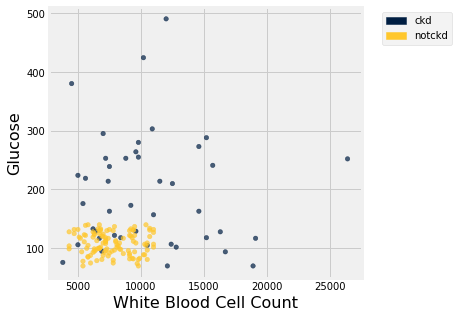

In [4]:
ckd.scatter('White Blood Cell Count', 'Glucose', colors='Class')

**Q:** As a human, how would you classify based on Glucose and White Blood Cell Count? 

<br/><br/><br/><br/><br/>

In [5]:
def my_classifier(wbc, glc):
    if wbc <= 12000 and glc <= 140:
        return 'notckd'
    else:
        return 'ckd'

In [6]:
my_classifier(8000, 100)

'notckd'

In [7]:
ckd_classified = ckd.with_column(
    'My Class', ckd.apply(my_classifier, 
                         'White Blood Cell Count',
                         'Glucose' )
)
ckd_classified.show(3)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class,My Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd,notckd
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,ckd,ckd
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,ckd,ckd


**Q:** How would you assess whether `my_classifier` is doing a good job?

<br/><br/><br/><br/><br/>

In [8]:
correct = ckd_classified.column('Class')\
  == ckd_classified.column('My Class')
correct

array([False,  True,  True,  True,  True, False,  True,  True,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True, False,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [9]:
np.sum(correct) / ckd_classified.num_rows

0.93670886075949367

In [10]:
np.mean(correct)

0.93670886075949367

**Problem:** we are misclassifying.  (We'll come back to this next lecture.)  What if we try another pair of variables?

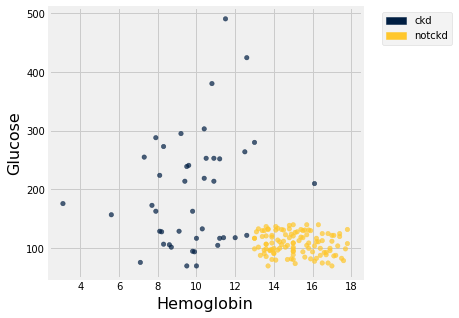

In [11]:
ckd.scatter('Hemoglobin', 'Glucose', colors='Class')

In [12]:
def another_classifier(hgb, glc):
    if glc <= 140 and hgb >= 13:
        return 'notckd'
    else:
        return 'ckd'

ckd_reclassified = ckd.with_column(
    'My Class', ckd.apply(another_classifier, 
                          'Hemoglobin', 
                          'Glucose')
)

np.mean(ckd_reclassified.column('Class') 
        == ckd_reclassified.column('My Class'))


1.0

**Problem:** What if we get a new individual to classify?

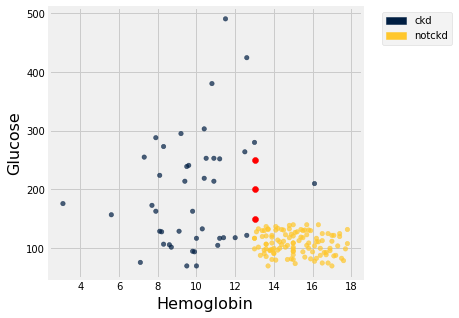

In [13]:
ckd.scatter('Hemoglobin', 'Glucose', colors='Class')
plots.scatter([13,13,13], [150,200,250], color='red');

**Q:** How would you label the bottom red point?

A. ckd  
B. notckd  


**Q:** How would you label the middle red point?

A. ckd  
B. notckd  


## Nearest Neighbor

**Distance between points.**

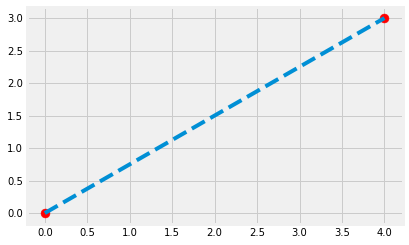

In [14]:
plots.scatter([0,4], [0,3], color='red', s=80);
plots.plot([0,4], [0,3], linestyle='dashed');

In [15]:
def distance(a, b):
    """Returns the distance between a and b, where a and b
    are both arrays representing points."""
    return np.sqrt(np.sum((a - b)**2))

In [16]:
distance(make_array(0,0), make_array(4,3))

5.0

**Classifying a new individual.**

In [17]:
hgb_glc = ckd.select('Hemoglobin', 'Glucose', 'Class')
hgb_glc    

Hemoglobin,Glucose,Class
11.2,117,ckd
9.5,70,ckd
10.8,380,ckd
5.6,157,ckd
7.7,173,ckd
9.8,95,ckd
12.5,264,ckd
10,70,ckd
10.5,253,ckd
9.8,163,ckd


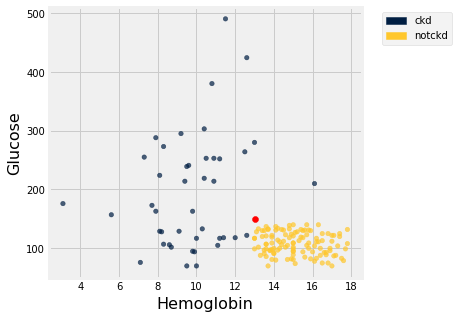

In [18]:
hgb_glc.scatter('Hemoglobin', 'Glucose', colors='Class')
plots.scatter([13], [150], color='red');

**Aside: Rows.**

In [19]:
hgb_glc.row(0)

Row(Hemoglobin=11.199999999999999, Glucose=117, Class='ckd')

In [20]:
np.array(hgb_glc.row(0))

array(['11.2', '117', 'ckd'],
      dtype='<U32')

In [21]:
np.array(hgb_glc.drop('Class').row(0))

array([  11.2,  117. ])

In [22]:
hgb_glc.drop('Class').apply(np.array)

array([[  11.2,  117. ],
       [   9.5,   70. ],
       [  10.8,  380. ],
       [   5.6,  157. ],
       [   7.7,  173. ],
       [   9.8,   95. ],
       [  12.5,  264. ],
       [  10. ,   70. ],
       [  10.5,  253. ],
       [   9.8,  163. ],
       [   9.1,  129. ],
       [  10.3,  133. ],
       [   7.1,   76. ],
       [  13. ,  280. ],
       [  16.1,  210. ],
       [  10.4,  219. ],
       [   9.2,  295. ],
       [  11.4,  118. ],
       [   8.1,  224. ],
       [   8.2,  128. ],
       [  12. ,  118. ],
       [  11.1,  105. ],
       [   7.9,  288. ],
       [   8.3,  273. ],
       [  12.6,  122. ],
       [  10.4,  303. ],
       [   8.7,  102. ],
       [   8.3,  107. ],
       [  10. ,  117. ],
       [   9.5,  239. ],
       [   9.9,   94. ],
       [   8.1,  129. ],
       [  11.2,  252. ],
       [   7.3,  255. ],
       [  10.9,  253. ],
       [  10.9,  214. ],
       [  11.5,  490. ],
       [   7.9,  163. ],
       [   9.6,  241. ],
       [   9.4,  214. ],


In [23]:
def mean_of_row(row):
    row_as_array = np.array(row)
    return np.mean(row_as_array)

hgb_glc.with_column(
    'Mean of row', hgb_glc.drop('Class').apply(mean_of_row)
)

Hemoglobin,Glucose,Class,Mean of row
11.2,117,ckd,64.1
9.5,70,ckd,39.75
10.8,380,ckd,195.4
5.6,157,ckd,81.3
7.7,173,ckd,90.35
9.8,95,ckd,52.4
12.5,264,ckd,138.25
10,70,ckd,40
10.5,253,ckd,131.75
9.8,163,ckd,86.4


**End Aside, back to classifying**

In [24]:
new_point = make_array(13, 150)

def distance_from_new(row):
    """Return the distance between row and new_point.
    Row is an input to the function and can change every
    time the function is called.  new_point is the same
    every time, though."""
    return distance(np.array(row), new_point)
    
distances = hgb_glc.with_column(
    'Distance', hgb_glc.drop('Class').apply(distance_from_new)
).sort('Distance')

distances

Hemoglobin,Glucose,Class,Distance
5.6,157,ckd,10.1863
15,140,notckd,10.198
15.7,140,notckd,10.3581
16.3,140,notckd,10.5304
14.8,139,notckd,11.1463
13.6,137,notckd,13.0138
14.1,137,notckd,13.0465
9.8,163,ckd,13.3881
7.9,163,ckd,13.9646
14.2,134,notckd,16.0449


**Note:** What we just did with `distance_from_new` is incredibly important to understand.

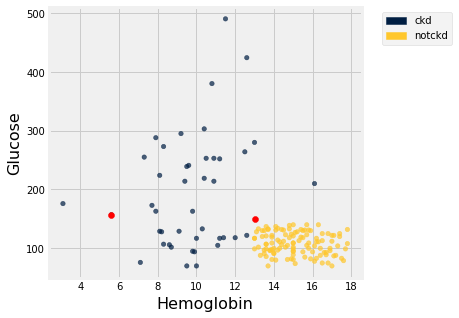

In [25]:
hgb_glc.scatter('Hemoglobin', 'Glucose', colors='Class')
plots.scatter([13, 5.6], [150, 157], color='red');

**Q:** What's wrong with my classifier?

A.  Nothing.  
B.  I must have coded the `distance` function wrong.  
C.  Something else is wrong.

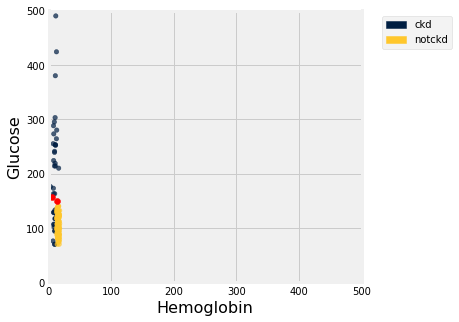

In [26]:
hgb_glc.scatter('Hemoglobin', 'Glucose', colors='Class')
plots.scatter([13, 5.6], [150, 157], color='red');
plots.xlim(0,500);
plots.ylim(0,500);

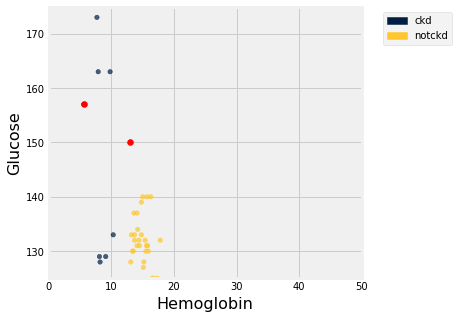

In [27]:
hgb_glc.scatter('Hemoglobin', 'Glucose', colors='Class')
plots.scatter([13, 5.6], [150, 157], color='red');
plots.xlim(0,50);
plots.ylim(125,175);